Embeddings are very cool. Today I would like to share how I used embeddings and classical machine learning to bring order into my picture library.

I, like many other people, use my phone camera quite liberally. I take pictures I want to keep, and I send pictures of price tags to friends and family for comparison. I document successful recipes and take pictures of documents as a digital copy to file away.

I don’t really sort my pictures, but I kind of expect that to magically happen.

That’s where embeddings come in. 

## Embeddings In One Sentences

Embeddings are numerical vector representations of data that capture specific features within a multi-dimensional space.

## Using Embeddings in Python

It is one thing to create a deep-learning model that learns to represent data in a feature space as an embedding. That is fairly involved and way out of scope for today.

Instead, I am using a model trained by someone else to embed my data. I will be using the ML models of [OpenCLIP](https://github.com/mlfoundations/open_clip).

First let's setup a python environment:

```sh
mamba create -n embeddings 'python==3.11' 'uv>=0.4'
mamba activate embeddings
uv pip install 'open-clip-torch==2.26.1' 'pillow==10.4.0'
```

The next thing is to choose a model. OpenCLIP has multiple models to go from text or image to embedding space. I will be using the model `ViT-B-32` but you can choose any from their list of models.


## Basic Example

To get started, I am downloading an example image from Wikimedia. I chose this [picture of a cat](https://commons.wikimedia.org/wiki/File:Tabby_cat_with_blue_eyes-3336579.jpg) as it comes without any strings attached. 


### Downloading the Image


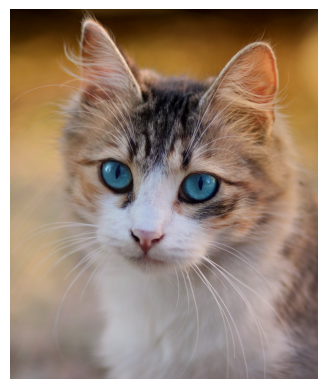

In [1]:
import os
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings

warnings.filterwarnings(
    "ignore", category=FutureWarning
)  # supress warnings for this post

url = "https://upload.wikimedia.org/wikipedia/commons/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg"
directory = "./data/embeddings"
if not os.path.exists(directory):
    os.makedirs(directory)

image_path = os.path.join(directory, "tabby_cat.jpg")
response = requests.get(url)
if response.status_code == 200:
    with open(image_path, "wb") as f:
        f.write(response.content)

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()

That is a beautiful cat image. But I rather have some numbers, would you not agree?

### Turning an Image into Numbers

To get numbers I use OpenClip to make an embedding of the picture.

In [2]:
import torch
from PIL import Image
import open_clip as oc
import textwrap

model_name, dataset_name = "ViT-B-32", "laion2b_s34b_b79k"
model, _, preprocess = oc.create_model_and_transforms(
    model_name, pretrained=dataset_name
)
model.eval()
image = preprocess(Image.open(image_path))
with torch.no_grad():
    embedding = model.encode_image(image.unsqueeze(0))[0]
    embedding_list = embedding.tolist()

formatted_output = textwrap.fill(
    " ".join(f"{num:.4f}" for num in embedding_list), width=80
)
print(f"The cat picture embedding is {len(embedding_list)} numbers long:")
print(formatted_output)

The cat picture embedding is 512 numbers long:
0.5008 1.5376 -0.2954 -0.6643 0.2076 0.3533 0.7771 -0.0469 -0.2705 0.3411 0.3498
0.2338 -0.0816 -0.1085 0.4557 0.4558 -1.3203 0.2224 -0.5656 0.2024 0.2359
-0.1147 -0.2847 0.1037 -0.4659 -0.3469 -0.0796 -0.2765 0.2792 -0.3212 -0.3535
0.2052 -0.2198 -0.0944 -0.3229 -0.0093 -0.0631 0.9892 -0.1790 -0.1151 0.0237
0.1114 0.7979 0.0580 -0.1842 -0.6418 0.7453 -0.4763 -0.2827 -0.3047 0.0762
1.3525 0.1879 -0.1763 -0.2691 -0.5180 -0.4092 -0.5020 0.0565 -0.1761 -0.5837
-0.2586 -0.3708 -0.0967 0.0574 -0.3979 0.0058 0.5315 -0.4134 -0.4211 -0.2468
0.2364 0.0282 0.1634 0.5892 0.3143 -0.1549 -0.1869 0.4169 0.2148 0.3625 0.8324
-0.1908 -0.0775 0.7071 -0.4733 0.6797 0.1581 -0.2133 -0.3093 -0.0362 0.1878
-0.0323 0.1521 -0.3625 -0.3153 -0.5103 0.1830 0.4676 0.2450 0.3215 -0.2646
-0.2983 -0.1510 -0.4240 0.4117 0.5254 0.4336 -0.4703 0.5798 -0.5942 -0.2342
-0.7455 -0.0936 -0.4396 0.9886 0.2256 -0.5390 0.0252 0.8686 -0.4021 -0.0826
-0.1723 -0.0252 0.1690 0.2896 0.

The cat image has turned into a vector of 512 floats. I choose to show all of them, so that one can get an impression how much or how little data is used to represent the image.

The cool thing is, that these numbers represent the cat image, and if we feed another cat image into the same embedding model it would end up very close in the “embedding space”. And furthermore, whatever image we feed in, small, large, cat or dog, it will always be a vector of floats with 512 numbers. Never more, never less.


## Scaling Up
To see what one can do with embeddings, I need more images. As I don't want to share my own pictures I will need to download some. But this is the internet, there are loads of images to download.

Today I will be using the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). It contains many images that belong each to one of the categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The images are very small (32x32 pixels), which makes it easy for me, but the techniques I show work with any image size.

### Getting the CIFAR10 dataset
This next code section will prepare the CIFAR10 dataset for later:

In [3]:
import os
import requests
import tarfile
import pickle
import numpy as np

np.random.seed(42)

# Define the target folder for embeddings
target_folder = "./data/embeddings/"


def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


def cifar10_dataset(
    url: str = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
    target_folder: str = "./data/embeddings",
):
    os.makedirs(target_folder, exist_ok=True)

    tar_path = os.path.join(target_folder, "cifar-10-python.tar.gz")
    if not os.path.exists(tar_path):
        response = requests.get(url)
        with open(tar_path, "wb") as f:
            f.write(response.content)

    extract_to = os.path.join(target_folder, "cifar-10-batches-py")

    if not os.path.exists(extract_to):
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=target_folder)

    data_batches = []
    for i in range(1, 6):
        batch = unpickle(f"{extract_to}/data_batch_{i}")
        data_batches.append(batch)

    # Combine the data from all batches
    X = np.concatenate([batch[b"data"] for batch in data_batches])
    y = np.concatenate([batch[b"labels"] for batch in data_batches])

    # Reshape the data to 32x32 images
    X = X.reshape(-1, 3, 32, 32)
    return X, y

Now with that out of the way, I sample 100 images and compute the embeddings for them. So in the end I end up with a matrix of size `100x512` (100 images, 512 numbers for each image).

In [4]:
import torch
from PIL import Image
import open_clip as oc
from tqdm import tqdm
import numpy as np


def load_open_clip_model(
    model_name: str = "ViT-B-32", dataset_name: str = "laion2b_s34b_b79k"
) -> tuple:
    model, _, preprocess = oc.create_model_and_transforms(
        model_name, pretrained=dataset_name
    )
    model.eval()
    return model, preprocess


def preprocess_images(images: np.ndarray, preprocess: callable) -> torch.Tensor:
    processed_images = []
    for img in tqdm(images, desc="Embedding images"):
        pil_image = Image.fromarray(img.transpose(1, 2, 0).astype(np.uint8))
        processed_image = preprocess(pil_image)
        processed_images.append(processed_image)
    return torch.stack(processed_images)


def get_embeddings(model, images: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        embeddings = model.encode_image(images)
    return embeddings


cifar10_images, cifar10_labels = cifar10_dataset()
sample_size: int = 100
indices: np.ndarray = np.random.choice(
    cifar10_images.shape[0], sample_size, replace=False
)
sampled_images: np.ndarray = cifar10_images[indices]
sampled_labels: np.ndarray = cifar10_labels[indices]

model, preprocess = load_open_clip_model()
processed_images: torch.Tensor = preprocess_images(sampled_images, preprocess)
embeddings: torch.Tensor = get_embeddings(model, processed_images)

Embedding images: 100%|██████████| 100/100 [00:00<00:00, 1363.67it/s]


So, now I got the 100 embeddings. If you where to look at them would look like this:

In [5]:
embeddings

tensor([[ 0.2725, -1.1369,  0.9518,  ..., -0.1577,  0.4148, -0.5571],
        [-0.4395, -0.8618, -0.1734,  ...,  0.5868,  0.0619, -0.4099],
        [-0.6377, -2.1732, -0.2041,  ..., -0.2980,  0.0348, -0.4055],
        ...,
        [ 0.4923, -1.4312,  0.7034,  ..., -0.3359,  0.2939, -0.2059],
        [ 0.1080, -0.9620, -0.2042,  ...,  0.1068, -0.0769, -0.0777],
        [ 0.3444, -1.4356,  0.6938,  ..., -0.2963, -0.2534, -0.3988]])

In other words, I have turned 100 images into a high dimensional (512) dataset. That is very useful for computers, but for a human brain this is challenging to understand.

To test if these numbers carry any meaning, because that's what you certainly are wondering, I will reduce them into two dimensions using UMAP:

In [6]:
import umap

reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.4)
embeddings_2D = reducer.fit_transform(embeddings.cpu().numpy())

Now that it's a 2D dataset I can make a scatterplot. And because they are images, I can show each image. If there is any information in those embeddings one should see that now:


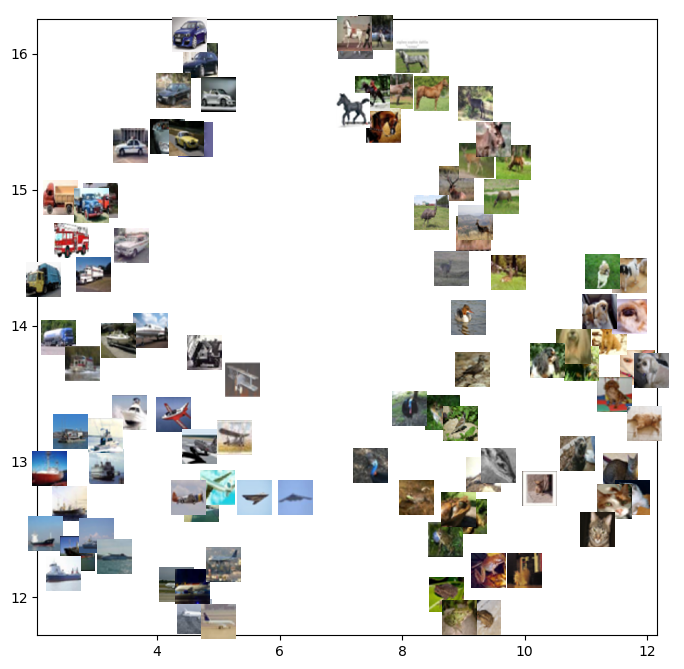

In [7]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

plt.figure(figsize=(8, 8))
pixel = 50
for i in range(len(embeddings_2D)):
    x, y = embeddings_2D[i]
    img = sampled_images[i].transpose(1, 2, 0)
    img = Image.fromarray(img.astype(np.uint8)).resize(
        (pixel, pixel)
    )  # Resize the image if needed
    imagebox = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(
        imagebox, (x, y), frameon=False
    )  # Create an AnnotationBbox

    plt.gca().add_artist(ab)  # Add the image to the plot

plt.xlim(np.min(embeddings_2D[:, 0]) - 0.1, np.max(embeddings_2D[:, 0]) + 0.1)
plt.ylim(np.min(embeddings_2D[:, 1]) - 0.1, np.max(embeddings_2D[:, 1]) + 0.1)
plt.show()

That is pretty cool, is it not? In the plot one can clearly see the animals grouped together and the vehicles grouped together. But looking closer (I know the resolution is pretty low), one can see that horses are grouped with horses and planes with planes.


## Learning labels

Now that I can go from an image into an embedding, the next step is to go from embeddings to predicting labels. 

This step should be familiar to anyone that has worked with machine learning in the past. 

I use scikit-learn for this and there are many, many more machine learning models you could try. I am using a single support vector machine (SVM), to demonstrate the approach. Other possible models include Random Forest or any other [classifier model](https://scikit-learn.org/1.5/auto_examples/classification/plot_classifier_comparison.html). 


First, I am sampling 500 images. I then use a 80% to 20% training and validation split. I don’t do any class balancing, cross-validation or hyper-parameter tuning here, as this is an example. If you want to achieve a higher accuracy I would suggest you look into these topics.



In [8]:
from sklearn.model_selection import train_test_split

# Load the dataset once
cifar10_images, cifar10_labels = cifar10_dataset()  # Load your dataset

# Sample images and labels
sample_size = 1000
indices = np.random.choice(cifar10_images.shape[0], sample_size, replace=False)
sampled_images = cifar10_images[indices]
sampled_labels = cifar10_labels[indices]

# Split the sampled images into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    sampled_images, sampled_labels, test_size=0.2, random_state=42
)

# Preprocess training images
processed_train_images = preprocess_images(train_images, preprocess)

# Get embeddings for training images
train_embeddings = get_embeddings(model, processed_train_images)

# Preprocess testing images
processed_test_images = preprocess_images(test_images, preprocess)

# Get embeddings for testing images
test_embeddings = get_embeddings(model, processed_test_images)

Embedding images: 100%|██████████| 200/200 [00:00<00:00, 1679.82it/s]


Now I have the embeddings for both the training images (800) and the test images (200). We can look at a few of the test images in a grid:



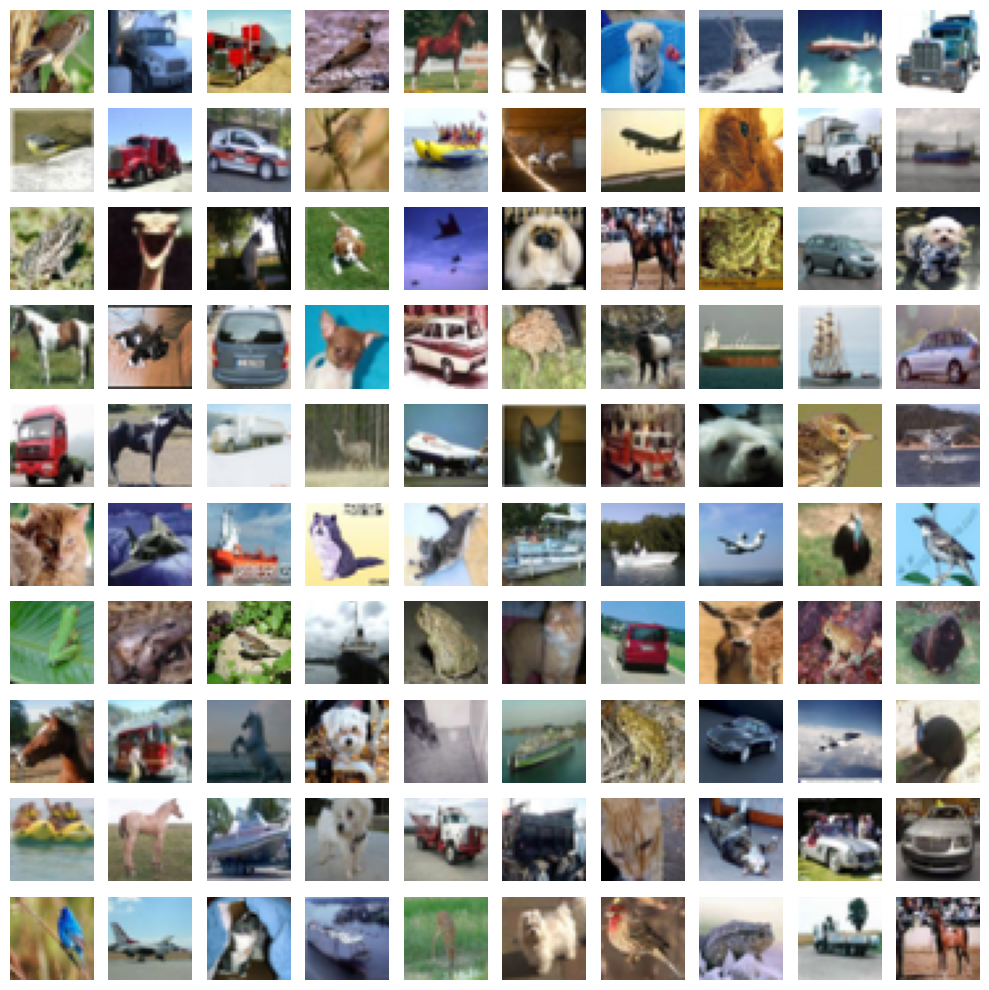

In [9]:
def plot_10x10_grid(
    images: np.ndarray,
    num_images: int = 10,
):
    _, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            if index < len(images):
                axes[i, j].imshow(images[index].transpose(1, 2, 0))
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()


plot_10x10_grid(test_images)

The images are clearly jumbled up and not very much sorted. I can now train a SVM model on the training data. That is very quick and easy to do:

In [10]:
from sklearn import svm

svm_model = svm.SVC(kernel="linear")
svm_model.fit(train_embeddings.numpy(), train_labels)

SVC(kernel='linear')

This SVM model now is trained and ready to be evaluated:


In [11]:
from sklearn.metrics import accuracy_score

test_predictions = svm_model.predict(test_embeddings.numpy())
accuracy = accuracy_score(test_labels, test_predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.00%


So overall, across all labels I get an accuracy of >95%, without any tuning or tricks on 32x32 pixel images. That is pretty impressive I would say. 

I can also break down the results on a per class level:

In [12]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       1.00      1.00      1.00        21
           2       1.00      0.83      0.91        24
           3       0.91      1.00      0.95        21
           4       1.00      1.00      1.00        11
           5       0.96      0.88      0.92        26
           6       0.90      1.00      0.95        18
           7       0.95      1.00      0.98        20
           8       0.96      1.00      0.98        25
           9       1.00      1.00      1.00        21

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



This shows that some classes can get a bit better results than for others. I next want to visualise this using a 10x10 grid of images:

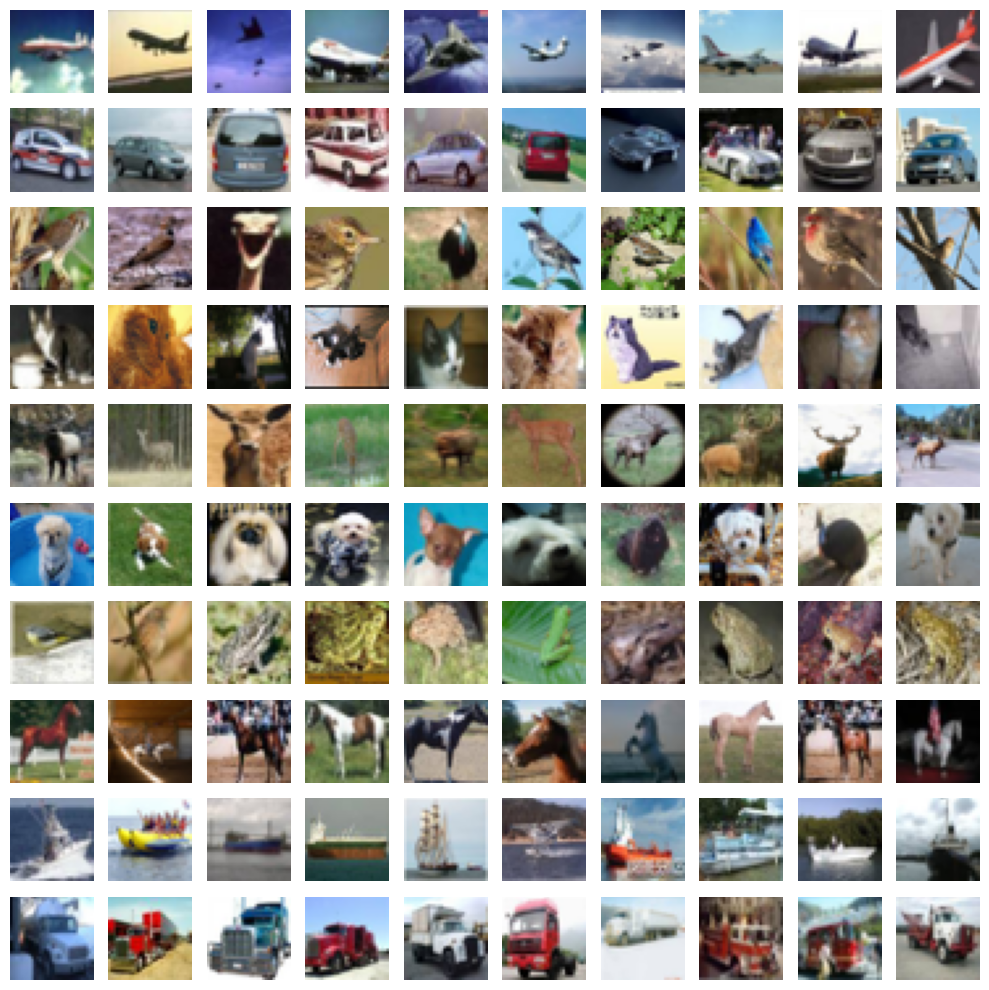

In [13]:
def plot_10x10_grid_predictions(
    images: np.ndarray,
    predictions: np.ndarray,
    num_images: int = 10,
):
    label_dict = {}

    # Organize images by predicted labels
    for img, pred in zip(images, predictions):
        if pred not in label_dict:
            label_dict[pred] = []
        label_dict[pred].append(img)

    num_labels = len(label_dict)
    _fig, axes = plt.subplots(
        num_labels, num_images, figsize=(num_images, num_labels)
    )

    labels = list(label_dict.keys())
    labels.sort()
    for i, key in enumerate(labels):
        imgs = label_dict[key]
        for j in range(num_images):
            if j < len(imgs):
                axes[i, j].imshow(imgs[j].transpose(1, 2, 0))
                axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()


plot_10x10_grid_predictions(test_images, test_predictions)

In this plot the images are sorted by their predicted class label. And I think it is very nice to see how each row contains mostly images of the correct class.

With that all wrapped up, I hope I showed how easy it can be to write an image classifier for your own photos, because the really heavy lifting has been done for you by people training deep neural networks.

All you need is to label a few images, probably as few as 5 per label will get you going. Then classify a batch and curate that classification to get labels for maybe 100 for each category. That should be enough to have a stable classifier that sorts your pictures into whatever groups you need, with a precision that is helpful and needs little to no curation afterwards.

One feature I only hinted at in this post is that these OpenCLIP embeddings are also valid for text. So embedding a sentence describing a picture would end up close to pictures of that type. Which makes them also great for searching by content. But that's a topic for another post.

I hope that was interesting. Have a great day.